<a href="https://colab.research.google.com/github/Alejandro-ZZ/Machine-Learning-UNS/blob/master/3_2_KNN_GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **K-Vecinos más cercanos (GridSearch)**

Se realizará la **evaluación de hiperparámetros** y la combinación de los mismos para un clasificador de **k-vecinos más cercanos** (knn). Se tomarán en cuenta los siguientes parámetros:

- ***n_neighbors:*** número de vecinos (k)
- ***weights:*** función de peso. Se incluyen: 'uniform' y 'distance'
- ***metric:*** métrica usada para calcular la distancia. Se incluyen: 'euclidean', 'manhattan' y 'minkowski'.

Se implementa la función ***GridSearchCV*** para obtener los resultados de cada combinación.

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from matplotlib.colors import ListedColormap

## **1. Dataset**

Se crea un conjunto de datos aleatorio de 2 *features* con distribución de campana.

            Distribution for the dataset


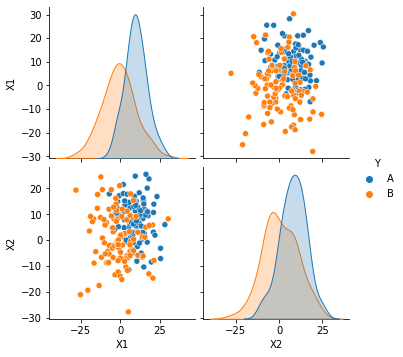

In [ ]:
# Total number of features of the dataset
num_features = 2

# Total number of samples for each label in target
num_samples = 100

# Creates a seed for random creation
np.random.seed(1)

# Creates column name for each feature
cols = ['X' + str(i+1) for i in range(num_features)]

# Values for target 'A'
target_A = pd.DataFrame(np.random.normal(loc=8.0, scale=8.0, size=(num_samples,num_features)),
                        columns=cols)
target_A['Y'] = 'A'

# Values for target 'B'
target_B = pd.DataFrame(np.random.normal(loc=0.0, scale=10.0, size=(num_samples,num_features)),
                        columns=cols)
target_B['Y'] = 'B'

# Join both target values in one dataframe
dataset = pd.concat([target_A, target_B])
dataset = dataset.reset_index(drop=True)

# Distribution plot
print(' '*12 + 'Distribution for the dataset')
sns.pairplot(data=dataset, diag_kind="kde", hue='Y')
plt.show()

## **2. Datos de entrenamiento y prueba**

Se procede a dividir el dataset en diferentes proporciones de entrenamiento y prueba.

In [ ]:
# All splits with different test sizes
splits = []

# Test sizes of each split to create
test_sizes = [0.2, 0.5, 0.7]

# Get data for features and target
X = dataset[dataset.columns[:-1]].to_numpy()
y = dataset[dataset.columns[-1]].to_numpy()

# Encodes target values from categorical to numerical
le = LabelEncoder()
y = le.fit_transform(y)

# Create the splits
for test_size in test_sizes:

  # Splits the features and target in train and test data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=4)

  # Adds the train, test split
  splits.append((X_train, X_test, y_train, y_test))

## **3. Grid search**

Se construye un modelo KNN por cada posible combinación dentro de la grilla de parámetros.

<br>

Primero, se crea una función que ejecute el *GridSearch*.

In [ ]:
def apply_GridSearch(X_train, y_train):
  '''
  Evaluates the grid search of a KNN model and returns an object of 
  <sklearn.model_selection.GridSearchCV> with all attributes of the 
  grid applied.
  '''
  # Maximun number of k-neighbors
  n_samples, n_features = X_train.shape
  Ks = int(n_samples / 2 + 10)

  # Model to apply GridSearch
  model = KNeighborsClassifier()

  # Grid params to evaluate
  parameters = {
      'n_neighbors': [n for n in range(2,Ks)],
      'weights': ['uniform', 'distance'],
      'metric': ['chebyshev', 'manhattan', 'minkowski']
  }

  # Applies the Grid Search
  grid_search = GridSearchCV(model, parameters, cv=5, return_train_score=False)
  grid_search.fit(X_train,y_train)

  return grid_search

Ahora se implementa la evaluación de los hiperparámetros para cada división de entrenamiento-prueba hecho.

In [ ]:
# Results of every grid search
grid_objects = []

for split in splits:
  X_train, X_test, y_train, y_test = split
  grid_objects.append(apply_GridSearch(X_train, y_train))

## **4. Resultados de entrenamiento**

Se extraen los resultados obtenidos para cada GridSearch y se analizan.

In [ ]:
def show_results(grid_object):
  '''
  Display a summary of the results gotten on a grid search.
  '''

  # Reads the results as a DataFrame
  results = pd.DataFrame(grid_object.cv_results_)

  # Gets the params values and its mean test score
  grid_summary = results[['param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_score']]


  print("\nEl mejor puntaje es {} con metric: {}, weight: {} y k = {}\n".format(grid_object.best_score_, 
                                                                                grid_object.best_params_['metric'],
                                                                                grid_object.best_params_['weights'], 
                                                                                grid_object.best_params_['n_neighbors']))

  # Display plots
  fig, axs = plt.subplots(1, 3, figsize=(17,4))

  axs[0].set_title('Gráfica 1')
  axs[0].set_xlabel('k vecinos más cercanos')
  axs[0].set_ylabel('Puntaje medio de prueba')
  sns.lineplot(x='param_n_neighbors', 
              y='mean_test_score', 
              ci=None, 
              hue='param_weights', 
              data=grid_summary,
              ax=axs[0])

  axs[1].set_title('Gráfica 2')
  axs[1].set_xlabel('k vecinos más cercanos')
  axs[1].set_ylabel('Puntaje medio de prueba')
  sns.lineplot(x='param_n_neighbors', 
              y='mean_test_score', 
              ci=None, 
              hue='param_metric', 
              data=grid_summary,
              ax=axs[1])

  axs[2].set_title('Gráfica 3')
  axs[2].set_xlabel('Distancia métrica')
  axs[2].set_ylabel('Puntaje medio de prueba')
  sns.barplot(x="param_metric", 
              y="mean_test_score", 
              hue="param_weights", 
              data=grid_summary,
              ax=axs[2])

  plt.show()


  # Get the top best scores
  print('\n', '-'*30, '\nTop 10 mejores combinaciones:\n', '-'*30)
  print(grid_summary.sort_values(by='mean_test_score', ascending=False, ignore_index=True).head(n=10))

### **4.1. Datos de prueba: 20%**

Primero se realiza un análisis tomando un 80% de los datos para entrenamiento.


El mejor puntaje es 0.83125 con metric: chebyshev, weight: uniform y k = 37



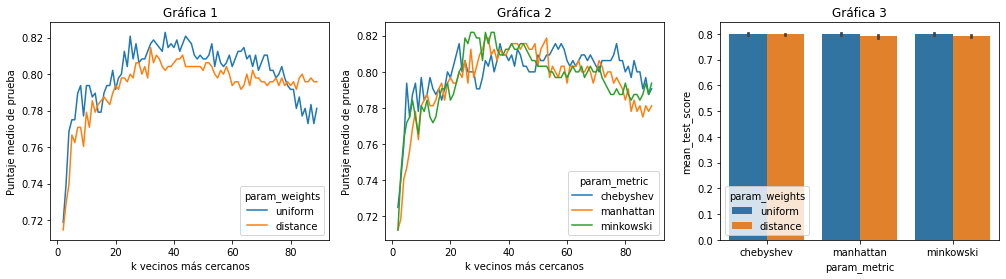


 ------------------------------ 
Top 10 mejores combinaciones:
 ------------------------------
  param_metric param_n_neighbors param_weights  mean_test_score
0    minkowski                25       uniform          0.83125
1    minkowski                27       uniform          0.83125
2    manhattan                53       uniform          0.83125
3    minkowski                35       uniform          0.83125
4    chebyshev                37       uniform          0.83125
5    manhattan                46       uniform          0.82500
6    chebyshev                23       uniform          0.82500
7    manhattan                37       uniform          0.82500
8    minkowski                46       uniform          0.82500
9    minkowski                45       uniform          0.82500


In [ ]:
# Gets the GridSearch object for split #1
grid_object = grid_objects[0]
show_results(grid_object)

**ANÁLISIS**

- Para la `gráfica 1` se observa que la mejor función de peso `weights`, para el clasificador y el dataset en mención, es `uniform` hasta valores de `k` cercanos a *80*.  

- Para las `gráfica 1` y `gráfica 2`, los comportamientos con mejores resultados se presentan conforme los k-vecinos más cercanos (`n_neighbors`) aumenta hasta valores cercanos a `k = 50`.

- Respecto al parámetro de la distancia (`metric`), la `gráfica 2` muestra un comportamiento similar para los tres parámetros evaluados.

- La relación entre el parámetro (`metric`) y la función peso (`weights`), según la `gráfica 3`, presentan puntajes muy similares ante variaciones de los mismos.

### **4.1. Datos de prueba: 50%**

Ahora se realiza un análisis los resultados para un 50% de los datos para entrenamiento.


El mejor puntaje es 0.8300000000000001 con metric: chebyshev, weight: uniform y k = 8



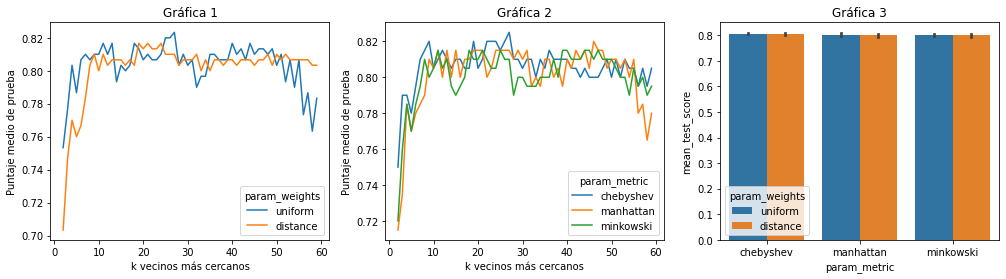


 ------------------------------ 
Top 10 mejores combinaciones:
 ------------------------------
  param_metric param_n_neighbors param_weights  mean_test_score
0    manhattan                46       uniform             0.83
1    chebyshev                24      distance             0.83
2    minkowski                18       uniform             0.83
3    chebyshev                27       uniform             0.83
4    chebyshev                23      distance             0.83
5    chebyshev                 8       uniform             0.83
6    manhattan                26       uniform             0.83
7    manhattan                25       uniform             0.83
8    manhattan                27       uniform             0.83
9    minkowski                45       uniform             0.82


In [ ]:
# Gets the GridSearch object for split #2
grid_object = grid_objects[1]
show_results(grid_object)

**ANÁLISIS**

- En la `gráfica 1`, se observa que para `k > 36` y `weights = 'distance'` el modelo no presenta cambios significativos.

- En la `gráfica 1`, se observa que para `k > 50` y `weights = 'uniform'` el modelo tiende a empeorar su puntaje.

- En general para las variables evaluadas en en el parámetro `metric`, para la `gráfica 2`, se observa un comportamiento similar. Sin embargo, para `k > 55` con `metric = 'manhattan'` el modelo tiende a desmejorar.

### **4.1. Datos de prueba: 70%**

Ahora se realiza un análisis los resultados para un 70% de los datos para entrenamiento.


El mejor puntaje es 0.9 con metric: manhattan, weight: uniform y k = 32



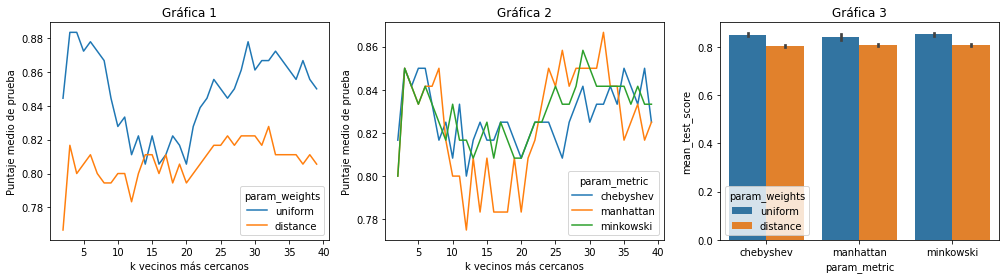


 ------------------------------ 
Top 10 mejores combinaciones:
 ------------------------------
  param_metric param_n_neighbors param_weights  mean_test_score
0    manhattan                32       uniform         0.900000
1    minkowski                29       uniform         0.900000
2    minkowski                30       uniform         0.883333
3    chebyshev                 5       uniform         0.883333
4    chebyshev                35       uniform         0.883333
5    chebyshev                 6       uniform         0.883333
6    manhattan                26       uniform         0.883333
7    manhattan                31       uniform         0.883333
8    chebyshev                38       uniform         0.883333
9    manhattan                34       uniform         0.883333


In [ ]:
# Gets the GridSearch object for split #3
grid_object = grid_objects[2]
show_results(grid_object)

**ANÁLISIS**

- En este análisis se observa que con `weight = 'uniform'`, el modelo presenta significativamente un mejor comportamiento en contraste con `weight = 'distance'`.

- Nuevamente, el comportamiento para el parámetro `metric` es muy similar conforme varian la cantidad de vecinos (`n_neighbors`).

- En este split, se obtiene el mayor puntaje respecto a los otros dos splits en la evaluación con GridSearchCV.

## **5. Resultados de prueba**

Analizado los resultados con los datos de entrenamiento, se procede a obtener el mejor modelo de cada *split* y evaluar su comportamiento con los datos de prueba.

In [ ]:
def regions_plot(X_train, y_train, knn_model, axis=None):

  # Crea un mapa de colores
  cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
  cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

  # Preparación para el gráfico 
  x_min, x_max = X_train[:, 0].min() - .1, X_train[:, 0].max() + .1
  y_min, y_max = X_train[:, 1].min() - .1, X_train[:, 1].max() + .1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                          np.linspace(y_min, y_max, 100))
  Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  if axis:
    axis.pcolormesh(xx, yy, Z, cmap=cmap_light)
    axis.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold)
    axis.set_xlabel('X')
    axis.set_ylabel('Y')
  else:
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

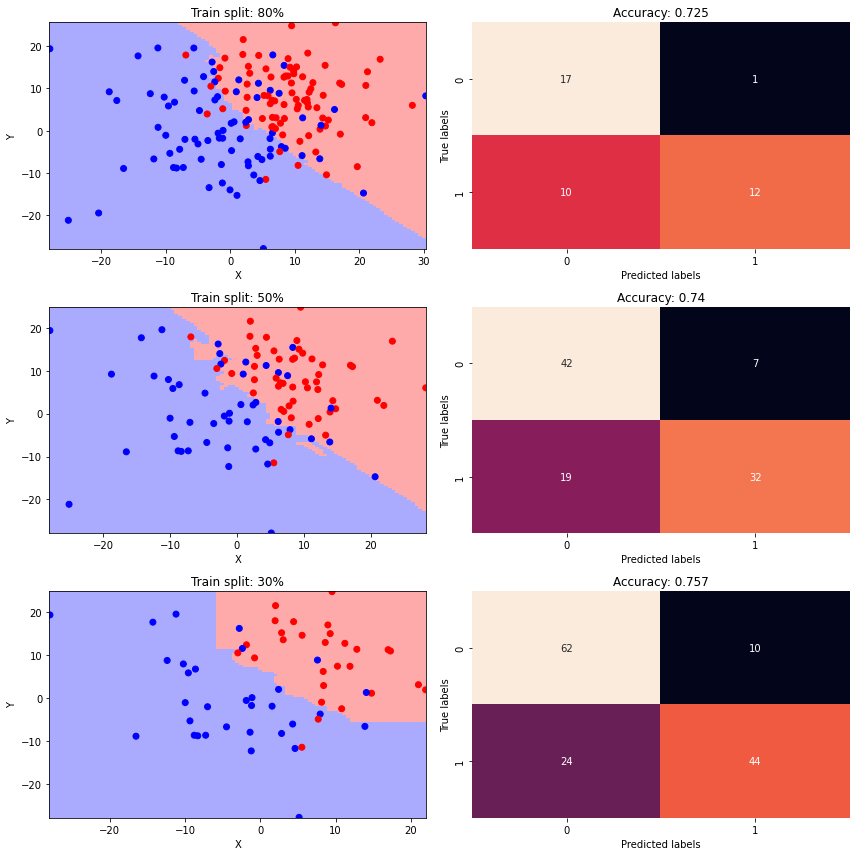

In [ ]:
fig, axs = plt.subplots(len(test_sizes), 2, figsize=(12,12))

for index in range(len(test_sizes)):

  X_train, X_test, y_train, y_test = splits[index]

  grid_object = grid_objects[index]
  model = grid_object.best_estimator_
  y_pred = model.predict(X_test)

  # Display test results
  # --------------------  

  # Plot regions
  train_size = 100 - int(test_sizes[index]*100)
  axs[index, 0].set_title(f'Train split: {train_size}%')
  regions_plot(X_train, y_train, model, axis=axs[index, 0])

  # Gets and displays the report
  report = metrics.classification_report(y_test, y_pred, output_dict=True)
  accuracy = round(report['accuracy'], 3)

  # Calculates the confusion matrix and shows it
  confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['True labels'], colnames=['Predicted labels'])
  sns.heatmap(confusion_matrix, annot=True, cbar=False, ax=axs[index, 1])
  axs[index, 1].set_title(f'Accuracy: {accuracy}')

plt.tight_layout()
plt.show()

# **Conclusión**

- Para el dataset generado, los mejores resultados se dieron para el split con el 50% de los datos para entrenamiento, seguido por el split  con el 30%.

- A partir de un análisis más extenso con la función **GridSearchCV**, se pueden evaluar la combinación de distintos hiperparámetros. En este caso se realizó únicamente para un modelo KNN, sin embargo, se pueden incluir otros modelos de clasificación y observar su comportamiento para los datos específicos.

- Si bien, este análisis exploratorio con **GridSearchCV** puede llegar a consumir recursos significativos de computación, existen funciones análogas de reducción como [HalvingGridsearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn.model_selection.HalvingGridSearchCV). 

- En este laboratorio se eligen la combinación de parámetros que obtuvieron la media de puntaje más alto. Sin embargo, en casos prácticos esta decisión depende de otras variables que permiten dar contexto a la aplicación final.